In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features
y = abalone.data.targets

#X = pd.get_dummies(X, columns=['Sex'])
X = X.drop(columns=['Sex'])

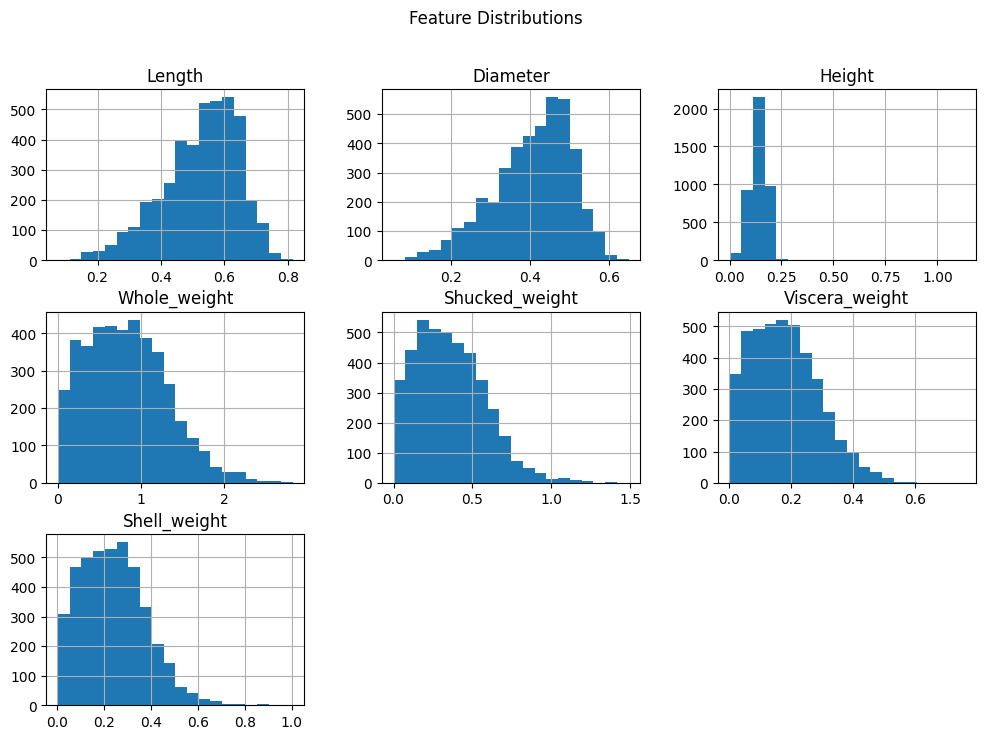

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

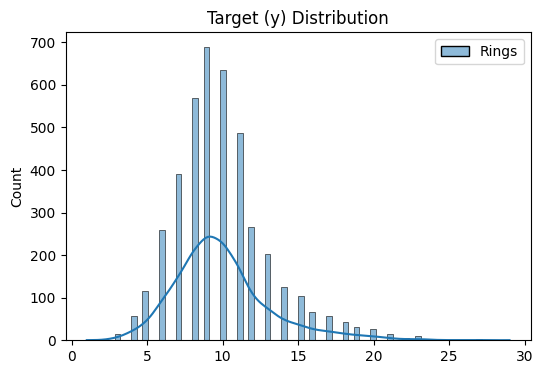

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

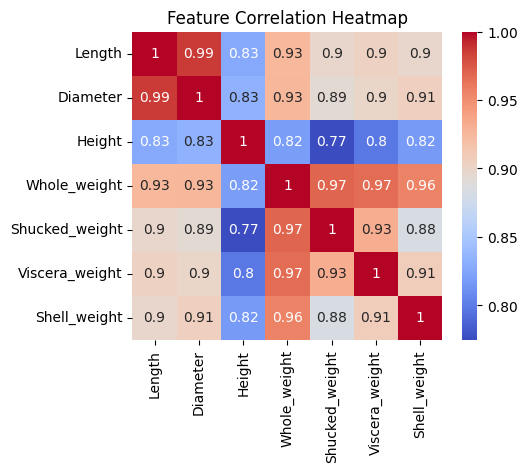

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=-2)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  MultiBART_Rhat_SplitProb  \
0                  1.044273             1.024963                  1.212170   
1                  1.059458             1.145983                  1.265375   
2                  1.164218             1.170927                  1.252732   
3                  1.093425             1.104802                  1.199934   
4                  1.026061             1.110113                  1.282115   
5                  1.343020             1.584016                  1.175222   
6                  1.083816             1.367988                  1.217609   
7                  1.038996             1.117929                  1.166968   
8                  1.069274             1.115047                  1.188132   
9                  1.172884             1.140618                  1.201621   
mean               1.109542             1.188239                  1.216188   
std                0.095900  

In [10]:
rhat_df.to_csv("results/real1_Abalone_rhat.csv", index=False)

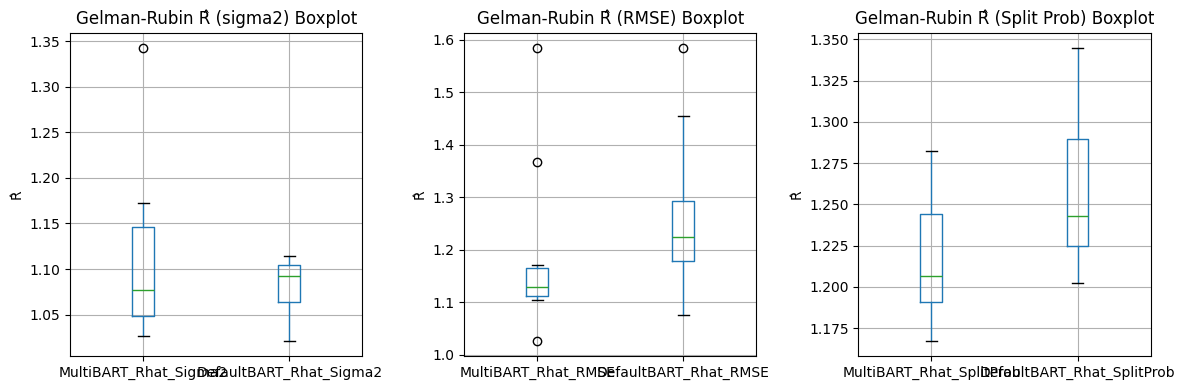

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

# split prob boxplot
rhat_df[["MultiBART_Rhat_SplitProb", "DefaultBART_Rhat_SplitProb"]].boxplot(ax=axes[2])
axes[2].set_title("Gelman-Rubin R̂ (Split Prob) Boxplot")
axes[2].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      4.860541  4.881667  4.903378  4.791655  5.722874
1      4.628343  4.651149  4.814521  4.574730  5.348410
2      5.263557  5.358666  5.341948  5.399027  5.810473
3      4.530774  4.502222  4.516953  4.645710  5.385919
4      4.383388  4.373722  4.469932  4.558238  5.046336
5      5.295010  5.020605  5.142657  5.052298  5.874977
6      5.044664  4.998123  4.866876  4.946810  5.660102
7      5.288502  5.285943  5.287504  5.139162  5.571136
8      5.133521  5.016118  4.828933  4.887725  5.738235
9      5.257053  5.216589  5.243740  5.280333  5.807626
mean   4.968535  4.930480  4.941644  4.927569  5.596609
std    0.345396  0.330888  0.307377  0.292084  0.261880



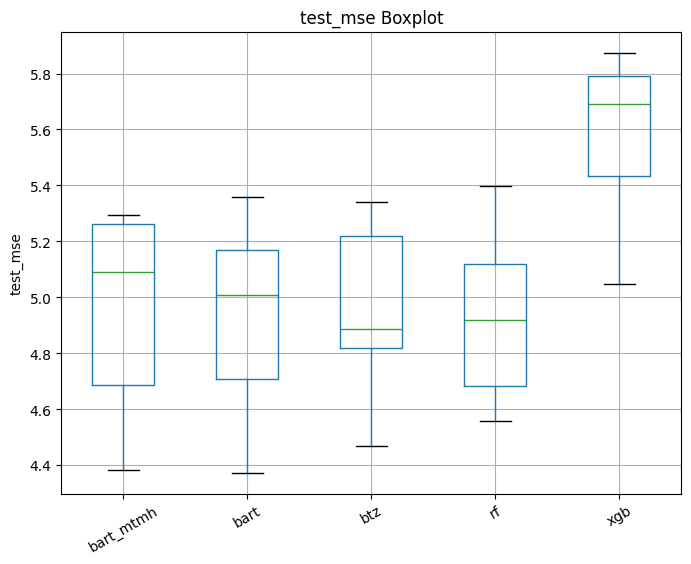

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      3.420849  3.930260  3.907227  0.679427  0.542755
1      3.333006  3.886769  3.998078  0.683244  0.606606
2      3.190442  3.669792  3.762385  0.639765  0.543232
3      3.432232  3.895094  3.964890  0.677036  0.545936
4      3.549810  3.987519  4.066865  0.681703  0.621954
5      3.192501  3.677430  3.831447  0.647193  0.533894
6      3.229627  3.765216  3.914979  0.680122  0.566025
7      3.201963  3.619364  3.772048  0.656752  0.540149
8      3.317604  3.810031  3.909686  0.674107  0.535856
9      3.243669  3.648128  3.734415  0.667631  0.549909
mean   3.311170  3.788960  3.886202  0.668698  0.558632
std    0.122901  0.131853  0.109325  0.015522  0.030849



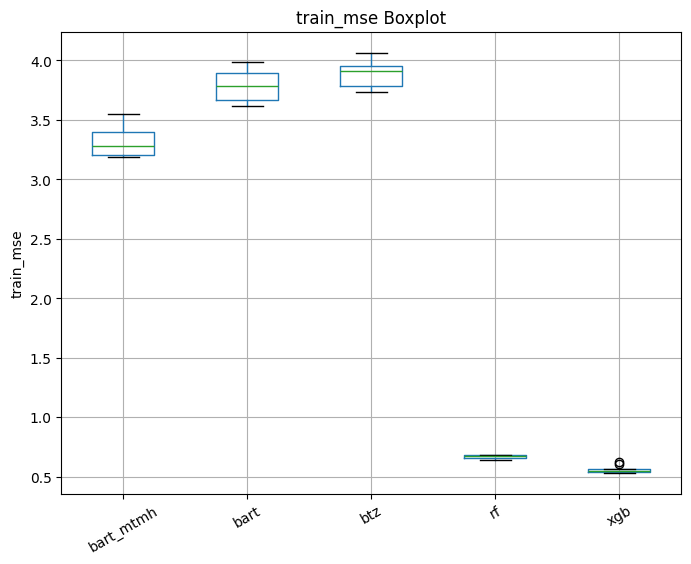

pi_length:
      bart_mtmh      bart       btz
0      8.109635  8.212761  8.325385
1      7.940570  8.194860  8.316846
2      7.892254  7.979379  8.190982
3      8.065333  8.145713  8.273290
4      8.252258  8.345709  8.417682
5      7.782372  7.961349  8.254346
6      7.824170  8.087868  8.292959
7      7.845635  7.912300  8.242685
8      7.954359  8.032867  8.314307
9      7.911244  7.999038  8.156194
mean   7.957783  8.087184  8.278468
std    0.145032  0.135968  0.073819



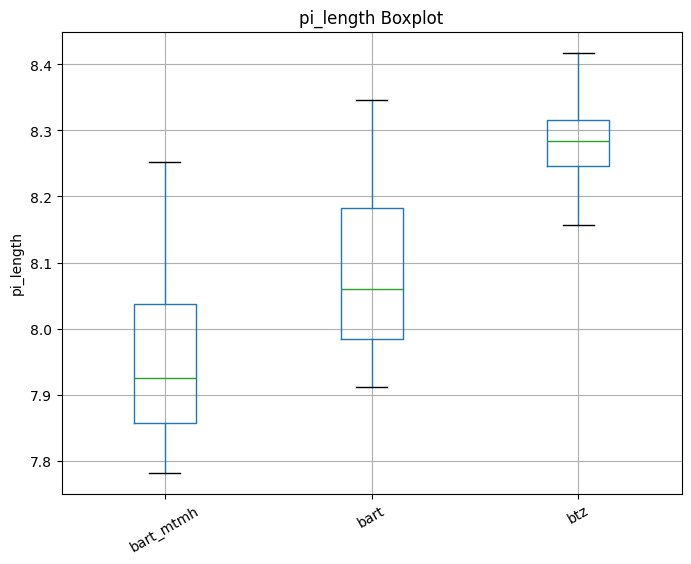

coverage:
      bart_mtmh      bart       btz
0      0.939713  0.940670  0.943541
1      0.925359  0.934928  0.934928
2      0.929187  0.924402  0.925359
3      0.933014  0.936842  0.938756
4      0.948325  0.941627  0.941627
5      0.918660  0.929187  0.926316
6      0.915789  0.923445  0.930144
7      0.919617  0.921531  0.928230
8      0.929187  0.929187  0.937799
9      0.926316  0.930144  0.929187
mean   0.928517  0.931196  0.933589
std    0.009956  0.007096  0.006587



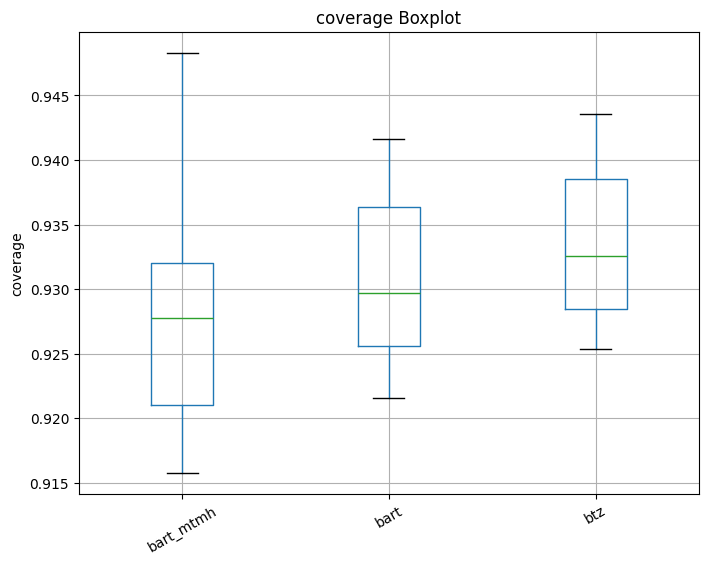

train_time:
       bart_mtmh       bart        btz        rf       xgb
0     220.056899  23.698393  34.908758  1.631176  0.312464
1     220.624026  23.542394  35.391290  1.467119  0.222997
2     222.181394  23.682886  38.281809  1.346483  0.228179
3     221.757422  23.700078  36.853227  1.393835  0.293643
4     220.749620  23.921922  35.511355  1.507838  0.224012
5     223.724463  25.766163  29.492926  1.507893  0.073047
6     222.325775  26.104867  29.268639  1.534193  0.069814
7     219.587981  24.514353  26.714766  2.800233  0.104047
8     220.030684  25.435961  28.346884  1.770409  0.096502
9     221.475693  37.551256  25.553487  1.317189  0.057504
mean  221.251396  25.791827  32.032314  1.627637  0.168221
std     1.281098   4.241376   4.617335  0.433161  0.098040



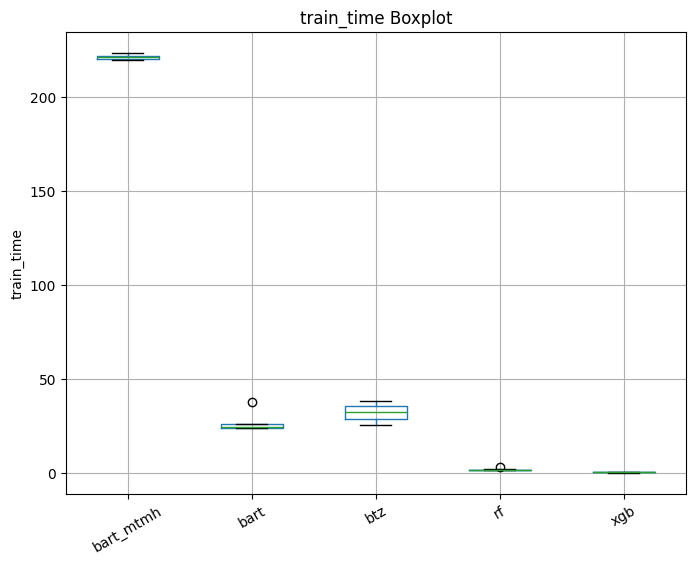

In [9]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [10]:
for k, v in mse_results.items():
    csv_name = f"results/real1_Abalone_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [11]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real1_Abalone_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real1_Abalone_tries.csv", index=False)

In [12]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.074454   1.379215  4.795435  0.931292    37.756892
1            5     1.074489   1.163688  4.694580  0.934928   116.716085
2           10     1.110819   1.143262  4.758144  0.936459   219.120015
3           50     1.105708   1.063309  4.841882  0.933014  1138.125280
